Загружаем необходимые библиотеки

In [1]:
%matplotlib inline
import numpy as np
import warnings

from scipy import sparse

from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import Ridge
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lars
from sklearn.metrics import precision_score, recall_score
from sklearn.base import clone
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import Perceptron
from scipy.sparse.linalg import svds
from sklearn.decomposition import PCA
import seaborn as sns
import numpy.ma as ma
import pandas as pd
from matplotlib.ticker import FormatStrFormatter
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 10)

Выключаем предупреждения вида 
```
UserWarning: Label not 83 is present in all training examples.
```
Такие сообщения возникают, если в данных не представлен какой-либо класс. Это будет происходит при кросс-валидации.

## Подготовка данных

Напишем функцию для считывания данных в разреженную матрицу.

In [3]:
def read_text_from_file(filename, shape):
    text = ["" for i in range(shape[0])]
    header = True
    for line in open(filename):
        if header:
            header = False
            continue
        row, col, value = [x for x in line.strip().split(',')]
        text[int(row) - 1] += col + ' '
    return text

In [6]:
def read_data_from_file(filename, shape):
    values = list()
    rows = list()
    cols = list()
    header = True
    for line in open(filename):
        if header:
            header = False
            continue
        row, col, value = [x for x in line.strip().split(',')]
        row, col = int(row), int(col)
        value = float(value)
        row -= 1
        col -= 1
        values.append(value)
        rows.append(row)
        cols.append(col)
        
    return sparse.csr_matrix((values, (rows, cols)), shape=shape)

Считаем данные

In [7]:
X_train = read_data_from_file('X_train.csv', (15000, 30000)).astype(float)
X_test = read_data_from_file('X_test.csv', (15000, 30000)).astype(float)
print(X_train.shape, X_test.shape)

(15000, 30000) (15000, 30000)


Нормируем признаки

In [9]:
from sklearn.preprocessing import scale

X_all = sparse.vstack([X_train, X_test])
X_all = scale(X_all, with_mean=False)
X_train = X_all[:15000, :]
X_test = X_all[15000:, :]

del X_all

Напишем функцию для считывания меток

In [8]:
def read_labels_from_file(filename, shape):
    labels = np.zeros(shape).astype(int)

    header = True
    for line in open(filename):
        if header:
            header = False
            continue
        row, indeces = line.strip().split(',')
        row = int(row) - 1
        indeces = [int(x) - 1 for x in indeces.split()]
        labels[row, indeces] = 1
    
    return labels

Считаем истинные метки

In [9]:
y_train = read_labels_from_file('y_train.csv', (15000, 98))
print(y_train.shape)

(15000, 98)


И, наконец, напишем функция для вывода меток в нужном формате

In [10]:
def write_labels_to_file(labels, filename):
    outfile = open(filename, 'w')
    outfile.write("Id,Labels\n")
    for i, line in enumerate(labels):
        elements = [str(x) for x in list(np.nonzero(line)[0] + 1)]
        outfile.write("%d,%s\n" % (i + 1, ' '.join(elements)))

### Подсчет F1

In [11]:
def cv_score(clf, X, y):
    cv = cross_val_score(clf, X, y, scoring = make_scorer(f1_score, average = 'samples'), cv = 5)
    print("CV:", cv)
    print("MEAN:", np.mean(cv))
    print("STD:", np.std(cv))

In [12]:
def cv_score11(clf, X, y):
    cv = cross_val_score(clf, X, y, scoring = make_scorer(f1_score, average = 'samples'), cv = 11)
    print("CV:", cv)
    print("MEAN:", np.mean(cv))
    print("STD:", np.std(cv))

### Функции для графиков:

In [13]:
def show_plot_with_confidence_interval(x, test_score, parameter_name):
    mean = np.mean(test_score, axis = 0)
    low = mean - 2 * np.std(test_score, axis = 0)
    high = mean + 2 * np.std(test_score, axis = 0)
    plt.figure(figsize=(6, 6))
    plt.fill_between(x, low, high, facecolor='green')
    handles = plt.plot(x, mean, color = 'blue', linewidth=1.5)
    plt.title('CV score and its confidence interval')
    plt.ylabel('f1_score')
    plt.xlabel(parameter_name)
    plt.legend(handles, ['mean'])
    plt.show()
    
def show_semilogx_with_confidence_interval(x, test_score, parameter_name):
    mean = np.mean(test_score, axis = 0)
    low = mean - 2 * np.std(test_score, axis = 0)
    high = mean + 2 * np.std(test_score, axis = 0)
    plt.figure(figsize=(6, 6))
    plt.fill_between(x, low, high, facecolor='green')
    handles = plt.semilogx(x, mean, color = 'blue', linewidth=1.5)
    plt.title('CV score and its confidence interval')
    plt.ylabel('f1_score')
    plt.xlabel(parameter_name)
    plt.legend(handles, ['mean'])
    plt.show()

def show_boxplot_with_confidence_interval(labels, test_score, parameter_name):
    data = pd.DataFrame(test_score, columns = labels)
    handles = data.boxplot(figsize=(5,11), return_type='axes', sym='k.', fontsize = 8, rot = 45)
    plt.title('CV score')
    plt.ylabel('f1_score')
    plt.xlabel('parameter')
    plt.show()
    
def print_parameters_plot(X, y, clf, parameter, values, function_to_show):
    parameters = {parameter: values}
    gs_clf = GridSearchCV(clf, parameters, cv = 5, scoring = make_scorer(f1_score, average = 'samples'))
    gs_clf.fit(X, y)
    test_score = np.array([gs_clf.cv_results_['split' + str(i) + '_test_score'] for i in range(0, 5)])
    function_to_show(values, test_score, parameter)

In [14]:
def print_parameters_heatmap(X, y, clf, parameter, values):
    parameters = {parameter[0]: values[0], parameter[1]: values[1]}
    gs_clf = GridSearchCV(clf, parameters, cv = 5, scoring = make_scorer(f1_score, average = 'samples'))
    gs_clf.fit(X, y)
    mean = np.mean(np.array([gs_clf.cv_results_['split' + str(i) + '_test_score'] for i in range(0, 5)]), axis = 0)
    res = mean.reshape(len(values[1]), len(values[0]))
    rounded_values_0 = [str(round(float(elem), 4)) for elem in values[0]]
    ax = plt.subplots(figsize=(6,3))
    ax = sns.heatmap(res * 100, yticklabels = values[1], xticklabels = rounded_values_0, annot=True, fmt='.2f')
    ax.set(xlabel = parameter[0], ylabel = parameter[1])
    #ax.yaxis.set_major_formatter(majorFormatter)
    sns.plt.title('CV f1_score')
    plt.show()
    #return pd.DataFrame(res, index = values[1], columns = values[0])

In [15]:
def MakeRandomClassifiers(outer_clfs, inner_clf, n_iter = 1):
    res = []
    for i in range(n_iter):
        clf = clone(inner_clf)
        clf.set_params(random_state = i + 1)
        for func in outer_clfs[::-1]:
            clf = func(clf)
        res.append(clf)
    return res

In [16]:
class UnionClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, clfs):
        self.clfs = np.array(clfs)
    
    def fit(self, X, y):
        for i in range(self.clfs.shape[0]):
            self.clfs[i].fit(X, y)

    def predict(self, X):
        res = []
        for i in range(self.clfs.shape[0]):
            res.append(self.clfs[i].predict(X))
        y_new = np.any(res, axis = 0)
        return y_new
    
    def get_params(self, deep = False):
        return {'clfs': self.clfs}

In [18]:
def UnionRandomOneVsRest(clf, n_iter = 1):
    res = UnionClassifier(MakeRandomClassifiers([ClassifierExtendY, OneVsRestClassifier], clf, n_iter))
    return res

# LR Baseline

In [29]:
clf = OneVsRestClassifier(LogisticRegression(C = 1))
%time cv_score(clf, X_train, y_train)

CV: [ 0.30994444  0.35085238  0.34671746  0.36735714  0.31738571]
MEAN: 0.338451428571
STD: 0.0215130829103
CPU times: user 3min 43s, sys: 252 ms, total: 3min 43s
Wall time: 4min 2s


# Проблема: ~33% предсказаний test пустые

## Исправления:

<b>Способ 1:</b> Рассмотрим предсказание у фиксированного наблюдения. Если у него больше 1 метки (x меток), разобьем его на x наблюдений. Получим уже обычную многоклассовую задачу, где каждому наблюдению соответствует 1 метка

### Multilabel $\to$ Multiclass

In [94]:
class ClassifierExtendY(BaseEstimator, ClassifierMixin):
    def __init__(self, clf):
        self.clf = clf

    def fit(self, X, y):
        y_new = np.argmax(y, axis = 1)
        X_new = X[y.nonzero()[0]]
        y_new = y.nonzero()[1]
        self.clf.fit(X_new, y_new)
        self.y_len = y.shape[1]

    def predict(self, X):
        y_new = np.zeros((X.shape[0], self.y_len))
        res = self.clf.predict(X)
        for i in range(res.shape[0]):
            y_new[i][res[i]] = 1
        return y_new
    
    def predict_proba(self, X):
        return self.clf.predict_proba(X)
    
    def get_params(self, deep = True):
        if (deep):
            res = {'clf': self.clf}
            for key, value in self.clf.get_params(deep = True).items():
                res.update({"clf__" + key: value})
            return res
        return {'clf': self.clf}

In [117]:
clf = ClassifierExtendY(OneVsRestClassifier(LogisticRegression(C = 1)))
%time cv_score(clf, X_train, y_train)

CV: [ 0.41972222  0.4692619   0.45809524  0.47771111  0.43268889]
MEAN: 0.451495873016
STD: 0.021953085198
CPU times: user 12min 12s, sys: 596 ms, total: 12min 13s
Wall time: 12min 25s


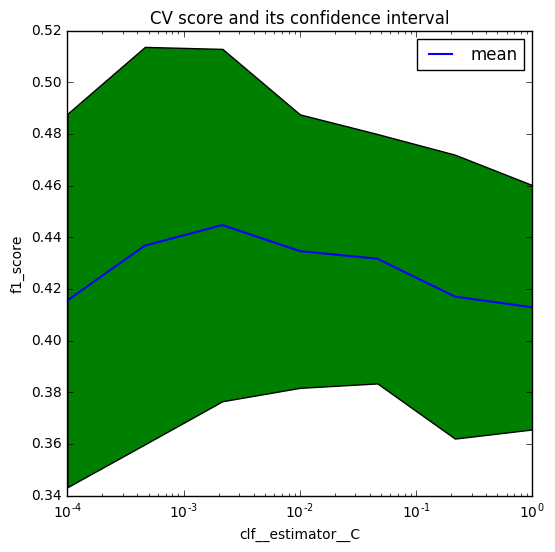

CPU times: user 3min 3s, sys: 300 ms, total: 3min 4s
Wall time: 3min 8s


In [118]:
%time print_parameters_plot(X_train[0:2000], y_train[0:2000], clf, 'clf__estimator__C', np.logspace(-4, 0, 7), show_semilogx_with_confidence_interval)

In [103]:
clf = ClassifierExtendY(OneVsRestClassifier(LogisticRegression(C = 0.003)))
%time cv_score(clf, X_train, y_train)

CV: [ 0.49611111  0.52410635  0.51287302  0.53582222  0.49007778]
MEAN: 0.511798095238
STD: 0.017015645207
CPU times: user 2min 36s, sys: 116 ms, total: 2min 36s
Wall time: 2min 41s


<b>Способ 2:</b> Каждый классификатор предскажет вероятность и по ней можно отсечь принимаем ли мы метку для данного наблюдения.

In [179]:
class HardProbaClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, clf, alpha):
        self.alpha = alpha
        self.clf = clf
    
    def fit(self, X, y):
        self.clf.fit(X, y)
        self.y_len = y.shape[1]
        
    def predict(self, X):
        res = []
        pred = self.clf.predict_proba(X)
        res = pred
        y_new = np.where(res >= self.alpha, 1, 0)
        return y_new
    
    def get_params(self, deep = True):
        if (deep):
            res = {'clf': self.clf, 'alpha': self.alpha}
            for key, value in self.clf.get_params(deep = True).items():
                res.update({"clf__" + key: value})
            return res
        return {'clf': self.clf, 'alpha': self.alpha}

In [189]:
clf = HardProbaClassifier(OneVsRestClassifier(LogisticRegression(C = 0.003)), alpha = 0.5)
%time cv_score(clf, X_train, y_train)

CV: [ 0.26738889  0.28661746  0.3058619   0.31132381  0.26985238]
MEAN: 0.288208888889
STD: 0.0179938598077
CPU times: user 1min 25s, sys: 108 ms, total: 1min 26s
Wall time: 1min 31s


In [181]:
print(clf.get_params())

{'clf': OneVsRestClassifier(estimator=LogisticRegression(C=0.003, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          n_jobs=1), 'clf__estimator__class_weight': None, 'clf__estimator__n_jobs': 1, 'clf__estimator__fit_intercept': True, 'clf__estimator__verbose': 0, 'alpha': 0.5, 'clf__estimator__C': 0.003, 'clf__estimator__tol': 0.0001, 'clf__estimator__dual': False, 'clf__n_jobs': 1, 'clf__estimator': LogisticRegression(C=0.003, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), 'clf__estimator__warm_start': False, 'clf__estimator__multi_class': 'ovr', 'clf__estimator__intercept_scaling': 1, 'clf__estimato

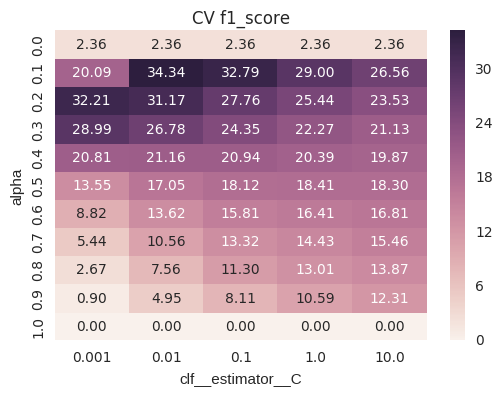

CPU times: user 20min 33s, sys: 772 ms, total: 20min 34s
Wall time: 21min 42s


In [210]:
clf__estimator__C = np.logspace(-3, 1, 5)
alpha = np.linspace(0, 1, 11)
%time print_parameters_heatmap(X_train[0:2000], y_train[0:2000], clf, ['clf__estimator__C', 'alpha'], [clf__estimator__C, alpha])

In [211]:
clf = HardProbaClassifier(OneVsRestClassifier(LogisticRegression(C = 0.01)), alpha = 0.1)
%time cv_score(clf, X_train, y_train)

CV: [ 0.41725218  0.43519628  0.44034334  0.46458176  0.41747817]
MEAN: 0.434970345846
STD: 0.0174680623387
CPU times: user 1min 49s, sys: 140 ms, total: 1min 49s
Wall time: 1min 56s


<b>Способ 3:</b> Каждый классификатор предскажет вероятность, но порог установлен не жестко, а равен $\alpha\cdot \max_j{P_{ij}}$, то есть максимум вероятностей по наблюдению. Это гарантирует, что каждому наблюдению будет соотнесена хотя бы одна метка

In [20]:
class MaxProbaClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, clf, alpha):
        self.alpha = alpha
        self.clf = clf
    
    def fit(self, X, y):
        self.clf.fit(X, y)
        self.y_len = y.shape[1]
        
    def predict(self, X):
        res = []
        pred = self.clf.predict_proba(X)
        res = pred
        maxs_1 = np.amax(res, axis = 1)
        maxs_1 = maxs_1.reshape((maxs_1.shape[0], 1))
        maxs = maxs_1 * self.alpha
        maxs = maxs.reshape((maxs.shape[0], 1))
        y_new = np.where(res >= maxs, 1, 0)
        return y_new
    
    def get_params(self, deep = True):
        if (deep):
            res = {'clf': self.clf, 'alpha': self.alpha}
            for key, value in self.clf.get_params(deep = True).items():
                res.update({"clf__" + key: value})
            return res
        return {'clf': self.clf, 'alpha': self.alpha}

In [214]:
clf = MaxProbaClassifier(OneVsRestClassifier(LogisticRegression(C = 0.003)), alpha = 0.5)
%time cv_score(clf, X_train, y_train)

CV: [ 0.52043781  0.53465802  0.52993276  0.55978239  0.5068324 ]
MEAN: 0.530328676786
STD: 0.0175289783126
CPU times: user 1min 26s, sys: 4 ms, total: 1min 26s
Wall time: 1min 26s


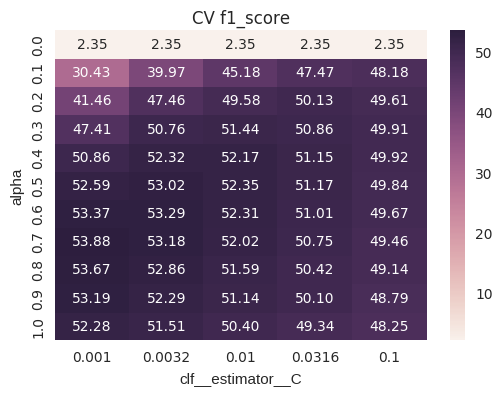

CPU times: user 1h 42min 29s, sys: 2.82 s, total: 1h 42min 32s
Wall time: 1h 44min


In [256]:
clf__estimator__C = np.logspace(-3, -1, 5)
alpha = np.linspace(0, 1, 11)
%time print_parameters_heatmap(X_train, y_train, clf, ['clf__estimator__C', 'alpha'], [clf__estimator__C, alpha])

In [257]:
clf = MaxProbaClassifier(OneVsRestClassifier(LogisticRegression(C = 0.001)), alpha = 0.7)
%time cv_score(clf, X_train, y_train)

CV: [ 0.5330532   0.54669681  0.53708442  0.56618322  0.51119817]
MEAN: 0.538843162708
STD: 0.0179444751281
CPU times: user 1min 9s, sys: 24 ms, total: 1min 9s
Wall time: 1min 9s


  Model                                                    |      5-Fold CV    |      Public   |     Private  
 --------------------------------------------------------- | ----------------- | ------------- | -------------
  Linear Regression (Baseline)                             |    0.33845        |    0.41989    |   0.42832    
  Linear Regression with extend y                          |    0.45150        |    0.51269    |   0.52792                    
  Linear Regression with extend y (C=0.003)                |    0.51180        |    0.56710    |   0.58141
  Linear Regression with thresholding (C=0.01, alpha=0.1)  |    0.43497        |    0.50465    |   0.51196
  Linear Regression, max thresholding (C=0.001, alpha=0.7) |    0.53884        |    0.59494    |   0.60815

# Уберем нормализацию данных

In [260]:
X_train = read_data_from_file('X_train.csv', (15000, 30000)).astype(float)
X_test = read_data_from_file('X_test.csv', (15000, 30000)).astype(float)
print(X_train.shape, X_test.shape)

(15000, 30000) (15000, 30000)


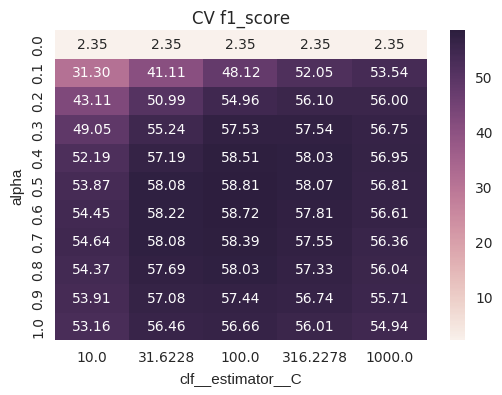

CPU times: user 1h 9min 50s, sys: 1.18 s, total: 1h 9min 52s
Wall time: 1h 10min 38s


In [271]:
clf__estimator__C = np.logspace(1, 3, 5)
alpha = np.linspace(0, 1, 11)
%time print_parameters_heatmap(X_train, y_train, clf, ['clf__estimator__C', 'alpha'], [clf__estimator__C, alpha])

In [273]:
clf = MaxProbaClassifier(OneVsRestClassifier(LogisticRegression(C = 100)), alpha = 0.5)
%time cv_score(clf, X_train, y_train)

CV: [ 0.58649792  0.59599002  0.5853418   0.60911561  0.56342222]
MEAN: 0.588073512784
STD: 0.0149871395553
CPU times: user 1min 10s, sys: 96 ms, total: 1min 10s
Wall time: 1min 14s


  Model                                                    |      5-Fold CV    |      Public   |     Private  
 --------------------------------------------------------- | ----------------- | ------------- | -------------
  LR (Baseline)                                            |    0.33845        |    0.41989    |   0.42832    
  LR max thresholding (C=0.001, alpha=0.7)                 |    0.53884        |    0.59494    |   0.60815
  LR max thresholding without normalization                |    0.58807        |    0.63663	   |   0.64501

# Обучим другие модели

In [21]:
def MaxProbaOneVsRest(clf, alpha = 1):
    res = MaxProbaClassifier(OneVsRestClassifier(clf), alpha)
    return res

### SGD Classifier

In [293]:
sgd_base_clf = SGDClassifier(alpha = 0.00003, n_iter = 50, loss = 'modified_huber', random_state = 1)
clf_sgd_proba = MaxProbaOneVsRest(sgd_base_clf, alpha = 0.7)
%time cv_score(clf_sgd_proba, X_train, y_train)

CV: [ 0.60349868  0.61235714  0.59904921  0.62179947  0.57404286]
MEAN: 0.602149470899
STD: 0.0160731627361
CPU times: user 53.1 s, sys: 56 ms, total: 53.2 s
Wall time: 56.2 s


![Image of Yaktocat](http://ogrisel.github.io/scikit-learn.org/sklearn-tutorial/_images/plot_sgd_loss_functions_1.png)

### Passive Aggressive Classifier

In [392]:
clf_pc = ClassifierExtendY(OneVsRestClassifier(PassiveAggressiveClassifier(C = 0.4, n_iter = 6, loss = 'squared_hinge', random_state = 43)))
%time cv_score(clf_pc, X_train, y_train)

CV: [ 0.57704444  0.59698413  0.58028413  0.60184444  0.5534    ]
MEAN: 0.581911428571
STD: 0.0171099302358
CPU times: user 11 s, sys: 4 ms, total: 11 s
Wall time: 11.7 s


In [301]:
pc_base_clf = PassiveAggressiveClassifier(C = 0.4, n_iter = 6, loss = 'epsilon_insensitive', random_state = 43)
clf_pc_all = UnionRandomOneVsRest(pc_base_clf, 50)
%time cv_score(clf_pc_all, X_train, y_train)

CV: [ 0.59975     0.60858254  0.59741587  0.61744048  0.57337778]
MEAN: 0.599313333333
STD: 0.0147712935785
CPU times: user 8min 53s, sys: 2.2 s, total: 8min 55s
Wall time: 9min 50s


### Linear SVM

In [324]:
clf_linear_svm = ClassifierExtendY(OneVsRestClassifier(LinearSVC(C = 1.5, max_iter = 10, random_state = 1)))
%time cv_score(clf_linear_svm, X_train, y_train)

CV: [ 0.5798      0.58359524  0.56789524  0.59473333  0.54801111]
MEAN: 0.574806984127
STD: 0.0159060620639
CPU times: user 19.5 s, sys: 12 ms, total: 19.5 s
Wall time: 19.7 s


In [325]:
linear_svm_base_clf = LinearSVC(C = 1.5, max_iter = 10)
clf_linear_svm_all = UnionRandomOneVsRest(linear_svm_base_clf, 20)
%time cv_score(clf_linear_svm_all, X_train, y_train)

CV: [ 0.59497143  0.59888757  0.58452698  0.61102619  0.56523016]
MEAN: 0.590928465608
STD: 0.0153947609087
CPU times: user 6min 18s, sys: 1.05 s, total: 6min 19s
Wall time: 6min 40s


  Model                                                    |      5-Fold CV    |      Public   |     Private  
 --------------------------------------------------------- | ----------------- | ------------- | -------------
  Linear Regression (best)                                 |    0.58807        |    0.63663	   |   0.64501
  SGD Classifier (modified huber)                          |    0.60215        |    0.64864	   |   0.65676    
  Passive Aggressive Classifier                            |    0.59931        |    0.64479	   |   0.65326
  Linear SVM                                               |    0.59093        |    0.63296	   |   0.64016

### KNN

In [329]:
clf_knn = ClassifierExtendY(KNN(metric = "cosine", n_neighbors = 41, algorithm = 'brute'))
%time cv_score(clf_knn, X_train, y_train)

CV: [ 0.53246667  0.53155079  0.51255079  0.5414      0.51217778]
MEAN: 0.526029206349
STD: 0.011676641653
CPU times: user 9.55 s, sys: 3.02 s, total: 12.6 s
Wall time: 37 s


### Random Forest

In [150]:
clf_forest = ClassifierExtendY(OneVsRestClassifier(RandomForestClassifier(n_estimators = 300)))
%time cv_score(clf_forest, X_train, y_train)

CV: [ 0.54261111  0.5431619   0.53262857  0.56856667  0.50771111]
MEAN: 0.538935873016
STD: 0.0196169236175
CPU times: user 5h 58min 14s, sys: 1 s, total: 5h 58min 15s
Wall time: 5h 58min 15s


# SVM

In [51]:
svm_base_clf = SVC(C = 1, gamma = 3, max_iter = -1, random_state = 1, probability = True)
clf_svm_proba = MaxProbaOneVsRest(svm_base_clf, 0.65)
%time cv_score(clf_svm_proba, X_train, y_train)
%time cv_score11(clf_svm_proba, X_train, y_train)

CV: [ 0.60777886  0.61584921  0.60103439  0.62570794  0.57711984]
MEAN: 0.605498047138
STD: 0.0164075288965
CPU times: user 3h 03min 26s, sys: 46.2s, total: 3h 04min 12s
Wall time: 3h 39min 11s
CV: [ 0.60982405  0.63966159  0.64919879  0.63823314  0.619619    0.61771633  0.6220081   0.66058706  0.63472732  0.60291025  0.57453097]
MEAN: 0.624456053626
STD: 0.022743254933
CPU times: user 6h 56min 3s, sys: 1min 6s, total: 6h 57min 9s
Wall time: 8h 29min 31s


### Подбор параметров

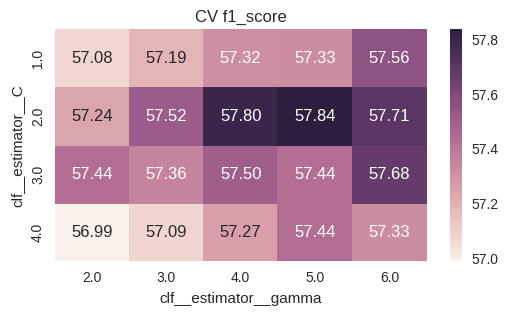

CPU times: user 4h 51min 31s, sys: 6.94 s, total: 4h 51min 38s
Wall time: 4h 56min 36s


In [25]:
clf__estimator__gamma = np.linspace(2, 6, 5)
clf__estimator__C = np.linspace(1, 4, 4)
%time print_parameters_heatmap(X_train[0:3000], y_train[0:3000], clf_svm_proba, ['clf__estimator__gamma', 'clf__estimator__C'], [clf__estimator__gamma, clf__estimator__C])

### SVM (best)

In [52]:
svm_base_clf = SVC(C = 2, gamma = 5, max_iter = -1, random_state = 1, probability = True)
clf_svm_proba = ProbaOneVsRest(svm_base_clf, 1, 0.65)
%time cv_score(clf_svm_proba, X_train, y_train)
%time cv_score11(clf_svm_proba, X_train, y_train)

CV: [ 0.60882381  0.6220754   0.60449735  0.62792143  0.57966667]
MEAN: 0.608596931217
STD: 0.0167864435969
CPU times: user 6h 17min 31s, sys: 2min 1s, total: 6h 19min 32s
Wall time: 6h 23min 4s
CV: [ 0.61629312  0.64336161  0.65041719  0.64733976  0.62614858  0.62559349  0.62740888  0.65839185  0.63697726  0.60695769  0.58539985]
MEAN: 0.629480844028
STD: 0.0202188942354
CPU times: user 9h 16min 19s, sys: 2min 2s, total: 9h 18min 21s
Wall time: 11h 49min 3s


# Объединяем модели

### Вариант 1

In [359]:
sgd_base_clf = SGDClassifier(alpha = 0.00003, n_iter = 50, loss = 'modified_huber', random_state = 1)
clf_sgd_proba = MaxProbaOneVsRest(sgd_base_clf, 0.85)
svm_base_clf2 = SVC(C = 2, gamma = 5, max_iter = -1, random_state = 1, probability = True)
clf_svm_proba2 = MaxProbaOneVsRest(svm_base_clf2, 0.7)
res_clf = UnionClassifier([clf_sgd_proba, clf_svm_proba2])
%time cv_score(res_clf, X_train, y_train)
%time cv_score11(res_clf, X_train, y_train)

CV: [ 0.61188915 0.62250079 0.60598704 0.63150397 0.57927778]
MEAN: 0.610231746032 
STD: 0.0177873532162 
CPU times: user 3h 28min 34s, sys: 39.5 s, total: 3h 29min 14s 
Wall time: 3h 49min 49s
CV: [ 0.61402039 0.64279256 0.64990748 0.64986734 0.62784062 0.62652213 0.62876693 0.65837264 0.64294449 0.60702232 0.5827691 ] 
MEAN: 0.630075090916 
STD: 0.0212336161775 
CPU times: user 9h 26min 3s, sys: 2min 12s, total: 9h 28min 15s 
Wall time: 10h 32min 59s

### Вариант 2

In [346]:
class SumClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, clfs):
        self.clfs = np.array(clfs)
    
    def fit(self, X, y):
        for i in range(self.clfs.shape[0]):
            self.clfs[i].fit(X, y)

    def predict_proba(self, X):
        res = []
        for i in range(self.clfs.shape[0]):
            if (i == 0):
                res = self.clfs[i].predict_proba(X)
            else:
                res += self.clfs[i].predict_proba(X)
        res /= len(self.clfs)
        return res
    
    def get_params(self, deep = False):
        return {'clfs': self.clfs}

In [352]:
sgd_base_clf = SGDClassifier(alpha = 0.00003, n_iter = 50, loss = 'modified_huber', random_state = 1)
svm_base_clf2 = SVC(C = 2, gamma = 5, max_iter = -1, random_state = 1, probability = True)
sum_clf = SumClassifier([sgd_base_clf, svm_base_clf2]);
clf_proba = MaxProbaOneVsRest(sum_clf, 0.7)
%time cv_score(clf_proba, X_train, y_train)
%time cv_score11(clf_proba, X_train, y_train)

CV: [ 0.6106 0.62503016 0.60875079 0.63105794 0.58232063] 
MEAN: 0.611551904762
STD: 0.0168841232356 
CPU times: user 3h 26min 41s, sys: 32.2 s, total: 3h 27min 13s 
Wall time: 3h 31min 18s
CV: [ 0.6148024 0.64522239 0.64929654 0.65119746 0.63328213 0.63469837 0.62755376 0.66067673 0.64060371 0.61040946 0.57892953] 
MEAN: 0.631515679442 
STD: 0.0220400870142 
CPU times: user 9h 29min 58s, sys: 1min 46s, total: 9h 31min 45s 
Wall time: 11h 34min 58s

  Model                                                    |      5-Fold CV    |  11-Fold CV |    Public   |     Private | Selected
 --------------------------------------------------------- | ----------------- | ----------- |------------ | ------------- | ------------ 
  SVM (C=1, gamma=3, 0.65)                                 |    0.60549        |  0.62446    |  0.65656	   |  0.66108 | 
  SVM (C=2, gamma=5, 0.65) $-$ best CV                     |    0.60860        |  0.62948    |  0.65650	   | 0.66655 | $\Large\checkmark$
  SVM (> 0.7) $\cup$ SGD ( > 0.85)                         |    0.61023        |  0.63008    |  0.65501	   |  0.66529 | 
  SVM + SGD (mean > 0.7)                                   |    0.61155        |  0.63152    |  0.65948	   | 0.66972 | $\Large\checkmark$

In [65]:
clf = clf_proba

In [ ]:
clf.fit(X_train, y_train)
y_test_lr = clf.predict(X_test)
write_labels_to_file(y_test_lr, 'y_test_lr.csv')